In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re
import missingno as msno
import datetime
import math as m
from sklearn.metrics import mean_absolute_error, mean_squared_error
%matplotlib inline

In [2]:
df = pd.read_csv('df4')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3347702 entries, 0 to 3347701
Data columns (total 24 columns):
 #   Column                Dtype  
---  ------                -----  
 0   Unnamed: 0            int64  
 1   index                 int64  
 2   SETTLEMENT_DATE       object 
 3   CLIENT_RECEIVER_NAME  object 
 4   CLIENT_RECEIVER_ACC   object 
 5   CLIENT_RECEIVER_BIC   object 
 6   FIN_CODE              int64  
 7   AMOUNT                float64
 8   CURRENCY              object 
 9   REASON1               object 
 10  REASON2               object 
 11  REG_DATE              object 
 12  REG_NO                object 
 13  SEBRA_PAY_CODE        int64  
 14  ORGANIZATION          object 
 15  PRIMARY_ORGANIZATION  object 
 16  DATE                  object 
 17  Year                  int64  
 18  Month                 int64  
 19  Day                   int64  
 20  IsBank                object 
 21  IsMunicipality        object 
 22  IsType                object 
 23  Prime M

In [4]:
df['SETTLEMENT_DATE'] = pd.to_datetime(df['SETTLEMENT_DATE'])
df['Date/Month'] = df['SETTLEMENT_DATE'].dt.to_period('M')

In [5]:
df2020 = df[df['Year']>2020]

<AxesSubplot:xlabel='Date/Month'>

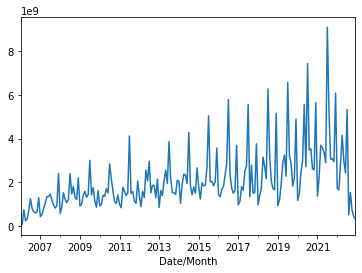

In [6]:
df.groupby('Date/Month').sum()['AMOUNT'].plot()

In [7]:
to_use = df.groupby('Date/Month').sum()
to_use

,Unnamed: 0,index,FIN_CODE,AMOUNT,SEBRA_PAY_CODE,Year,Month,Day
Date/Month,,,,,,,,
2006-01,18872136,18872136,544592848551,3.875447e+07,17976,994976,496,4884
2006-02,42610502,42610502,642044533145,5.333374e+07,33688,2174504,2168,10803
2006-03,45790144,45790144,1746142523566,7.315916e+08,53331,2834478,4239,13085
2006-04,62905145,62905145,1876519036320,2.244364e+08,68470,3656938,7292,17242
2006-05,51372887,51372887,2821575914847,3.217164e+08,63933,2844508,7090,13619
...,...,...,...,...,...,...,...,...
2022-08,8743756538,8743756538,4097521166488,5.000478e+08,89255,5046912,19968,9552
2022-09,7335525982,7335525982,4711649935313,1.520100e+09,81767,4213848,18756,9092
2022-10,14203957956,14203957956,7647764845626,7.024866e+08,227092,8217408,40640,13886


In [8]:
import plotly.express as px

fig = px.line(x=to_use.index.astype(str), y=to_use['AMOUNT'], title='Gov. spending throughout the years')
fig.show()

In [9]:
#Let's split the data set into a validaton 
#We want to have 3 years for validation and 13 for training the split is rougly 76% training and 24% validation
get_perc = 13/(len(to_use.index)/12)
print('Split here:', get_perc)
get_index = 13*12

split = round(len(to_use)*0.8)
train = to_use[:get_index]
test = to_use[get_index:]

Split here: 0.7647058823529411


<AxesSubplot:title={'center':'Gov spending'}, xlabel='Date/Month'>

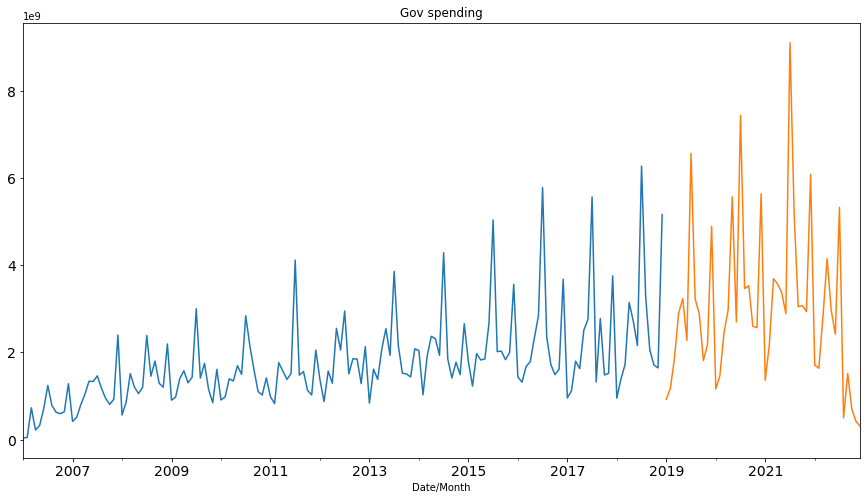

In [10]:
train.AMOUNT.plot(figsize=(15,8), title= 'Gov spending', fontsize=14, label='train') 
test.AMOUNT.plot(figsize=(15,8), title= 'Gov spending', fontsize=14, label='test')

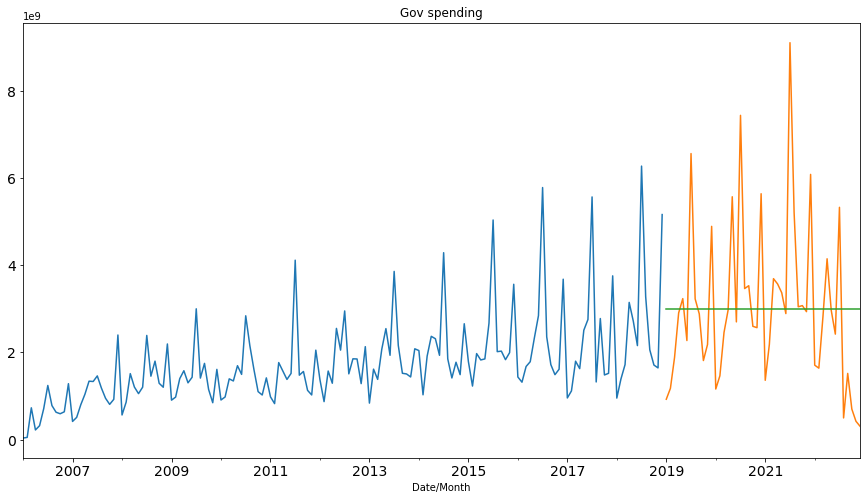

Mean absolute error:  1326782096.1252105
Mean_squared_error 3.381260394858762e+18
Root mean squared error:  1838820381.3474448


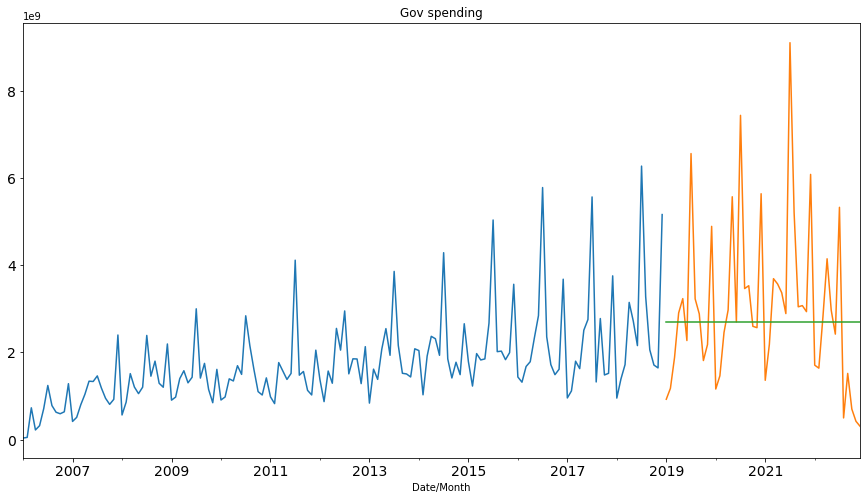

Mean absolute error:  1329361805.1391509
Mean_squared_error 3.5045403271553884e+18
Root mean squared error:  1872041753.582272


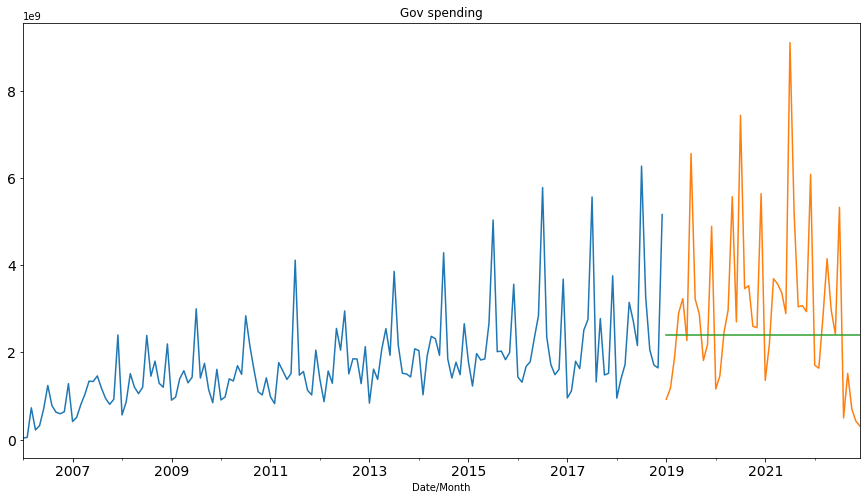

Mean absolute error:  1388174346.7033803
Mean_squared_error 3.8180228388041764e+18
Root mean squared error:  1953976161.26814


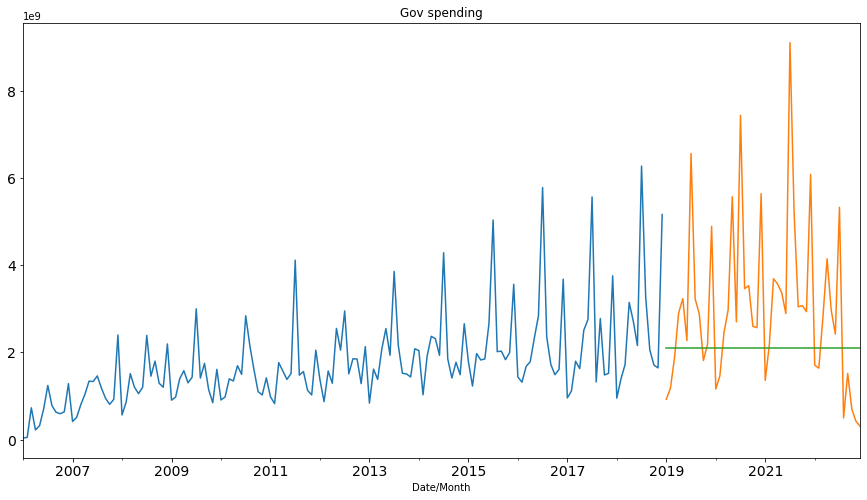

Mean absolute error:  1489913639.4550064
Mean_squared_error 4.299848863577839e+18
Root mean squared error:  2073607692.7851708


In [11]:
#Let's do a moving average approach
copied = test.copy()

#See rolling avg for 10, 20, 50
for roll in [10, 20, 50, 100]:
    copied['Mov. avg'] = train['AMOUNT'].rolling(roll).mean().iloc[-1]

    train.AMOUNT.plot(figsize=(15,8), title= 'Gov spending', fontsize=14, label='train') 
    test.AMOUNT.plot(figsize=(15,8), title= 'Gov spending', fontsize=14, label='test')
    plt.plot(copied['Mov. avg'], label='Moving Average Forecast using' + str(roll) +' observations')
    plt.show()
    mae = mean_absolute_error(test['AMOUNT'], copied['Mov. avg'])
    mse = mean_squared_error(test['AMOUNT'], copied['Mov. avg'])
    rms = m.sqrt(mean_squared_error(test['AMOUNT'], copied['Mov. avg'])) 
    print('Mean absolute error: ', mae)
    print('Mean_squared_error', mse)
    print('Root mean squared error: ',rms)
    

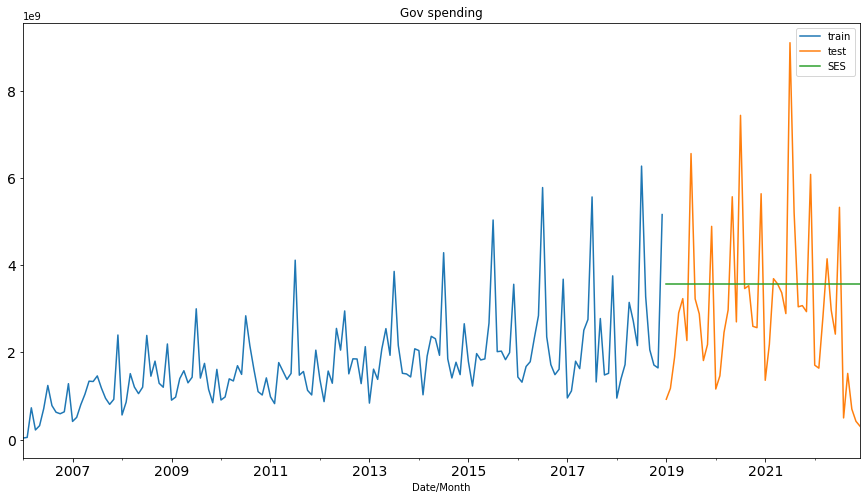

Mean absolute error:  1534468075.100439
Mean_squared_error 3.6467576233182863e+18
Root mean squared error:  1909648560.1592474


In [12]:
#The furhter back we roll, the less we respect the trend of the spending. Older years, with smaller gov spending affect the forecast.
#Let's try a Simple Exponential Smoothing
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt 
fit2 = SimpleExpSmoothing(np.asarray(train['AMOUNT'])).fit(smoothing_level=0.5, optimized=False) 
copied['SES'] = fit2.forecast(len(test))

#Plot result
plt.figure(figsize=(16,8))  
train.AMOUNT.plot(figsize=(15,8), title= 'Gov spending', fontsize=14, label='train') 
test.AMOUNT.plot(figsize=(15,8), title= 'Gov spending', fontsize=14, label='test')
plt.plot(copied['SES'], label='SES') 
plt.legend(loc='best') 
plt.show()
mae = mean_absolute_error(test['AMOUNT'], copied['SES'])
mse = mean_squared_error(test['AMOUNT'], copied['SES'])
rms = m.sqrt(mean_squared_error(test['AMOUNT'], copied['SES'])) 
print('Mean absolute error: ', mae)
print('Mean_squared_error', mse)
print('Root mean squared error: ',rms)

In [13]:
#Let's try a Holt regression
import statsmodels.api as sm 
train.reset_index(inplace=True)
train

,Date/Month,Unnamed: 0,index,FIN_CODE,AMOUNT,SEBRA_PAY_CODE,Year,Month,Day
0,2006-01,18872136,18872136,544592848551,3.875447e+07,17976,994976,496,4884
1,2006-02,42610502,42610502,642044533145,5.333374e+07,33688,2174504,2168,10803
2,2006-03,45790144,45790144,1746142523566,7.315916e+08,53331,2834478,4239,13085
3,2006-04,62905145,62905145,1876519036320,2.244364e+08,68470,3656938,7292,17242
4,2006-05,51372887,51372887,2821575914847,3.217164e+08,63933,2844508,7090,13619
...,...,...,...,...,...,...,...,...,...
151,2018-08,39404557293,39404557293,20500759889222,3.281928e+09,687771,33200136,131616,286725
152,2018-09,36083138199,36083138199,15389387985118,2.060688e+09,618059,30358792,135396,250213
153,2018-10,39352041187,39352041187,18959901935599,1.712444e+09,664526,32568502,161390,309068
154,2018-11,43276430120,43276430120,18764870092046,1.646388e+09,793502,35777122,195019,319320


In [14]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 156 entries, 0 to 155
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype    
---  ------          --------------  -----    
 0   Date/Month      156 non-null    period[M]
 1   Unnamed: 0      156 non-null    int64    
 2   index           156 non-null    int64    
 3   FIN_CODE        156 non-null    int64    
 4   AMOUNT          156 non-null    float64  
 5   SEBRA_PAY_CODE  156 non-null    int64    
 6   Year            156 non-null    int64    
 7   Month           156 non-null    int64    
 8   Day             156 non-null    int64    
dtypes: float64(1), int64(7), period[M](1)
memory usage: 11.1 KB


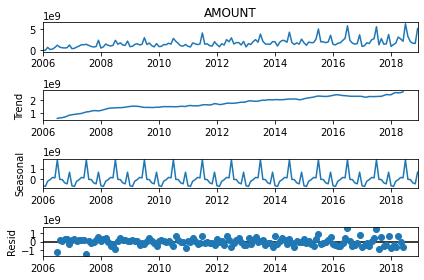

<Figure size 1152x576 with 0 Axes>

In [15]:
from pandas.tseries import frequencies
train = train.set_index('Date/Month').asfreq('M')

train.index = train.index.to_timestamp()
sm.tsa.seasonal_decompose(train['AMOUNT']).plot() 
result = sm.tsa.stattools.adfuller(train.AMOUNT) 
plt.figure(figsize=(16,8))
plt.show()

In [16]:
train

,Unnamed: 0,index,FIN_CODE,AMOUNT,SEBRA_PAY_CODE,Year,Month,Day
Date/Month,,,,,,,,
2006-01-01,18872136,18872136,544592848551,3.875447e+07,17976,994976,496,4884
2006-02-01,42610502,42610502,642044533145,5.333374e+07,33688,2174504,2168,10803
2006-03-01,45790144,45790144,1746142523566,7.315916e+08,53331,2834478,4239,13085
2006-04-01,62905145,62905145,1876519036320,2.244364e+08,68470,3656938,7292,17242
2006-05-01,51372887,51372887,2821575914847,3.217164e+08,63933,2844508,7090,13619
...,...,...,...,...,...,...,...,...
2018-08-01,39404557293,39404557293,20500759889222,3.281928e+09,687771,33200136,131616,286725
2018-09-01,36083138199,36083138199,15389387985118,2.060688e+09,618059,30358792,135396,250213
2018-10-01,39352041187,39352041187,18959901935599,1.712444e+09,664526,32568502,161390,309068


<ipython-input-17-9719e040ef41>:1: FutureWarning:

the 'smoothing_slope'' keyword is deprecated, use 'smoothing_trend' instead



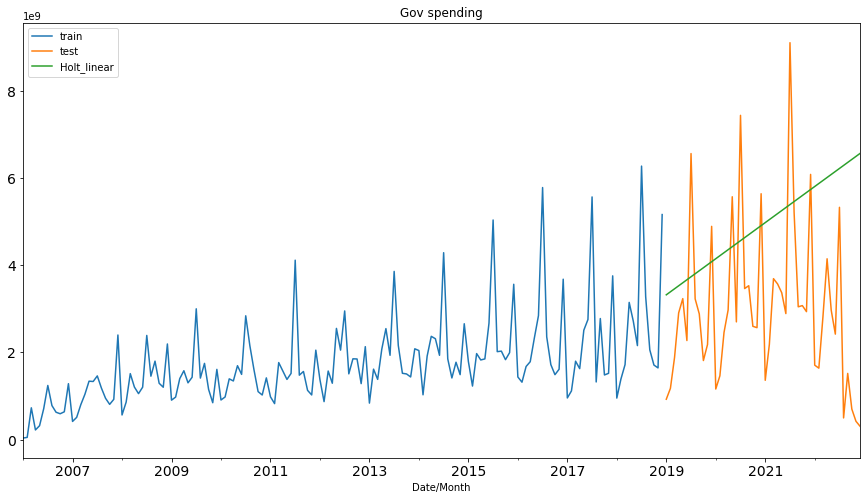

Mean absolute error:  2408160508.648336
Mean_squared_error 8.09053866033915e+18
Root mean squared error:  2844387220.534354


In [17]:
fit1 = Holt(np.asarray(train['AMOUNT'])).fit(smoothing_level = 0.3,smoothing_slope = 0.1) 
copied['Holt_linear'] = fit1.forecast(len(test)) 
plt.figure(figsize=(16,8))

train.AMOUNT.plot(figsize=(15,8), title= 'Gov spending', fontsize=14, label='train') 
test.AMOUNT.plot(figsize=(15,8), title= 'Gov spending', fontsize=14, label='test')
plt.plot(copied['Holt_linear'], label='Holt_linear') 
plt.legend(loc='best') 
plt.show()
mae = mean_absolute_error(test['AMOUNT'], copied['Holt_linear'])
mse = mean_squared_error(test['AMOUNT'], copied['Holt_linear'])
rms = m.sqrt(mean_squared_error(test['AMOUNT'], copied['Holt_linear'])) 
print('Mean absolute error: ', mae)
print('Mean_squared_error', mse)
print('Root mean squared error: ',rms)

In [18]:
#The Holt linear model does not really predict properly 

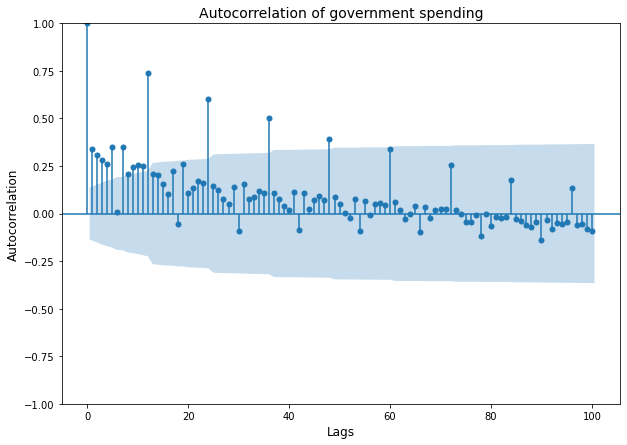

In [19]:
#Auto-regression

from statsmodels.graphics.tsaplots import plot_acf

plt.rc("figure", figsize=(10, 7))
# Plot ACF of JPM stock prices for past 40 lags
plot_acf(to_use.AMOUNT, lags=100)
plt.xlabel('Lags', fontsize=12)
plt.ylabel('Autocorrelation', fontsize=12)
plt.title('Autocorrelation of government spending', fontsize=14)
plt.show()


In [20]:
#Check stationarity
from statsmodels.tsa.stattools import adfuller
statio = adfuller(to_use['AMOUNT'], autolag='AIC')
print(statio)
print("P-value: ", statio[1])
#This means that data is not stationary or not with a constant trend

(-2.0917273347592626, 0.24785406698517454, 15, 188, {'1%': -3.465620397124192, '5%': -2.8770397560752436, '10%': -2.5750324547306476}, 8208.652576562057)
P-value:  0.24785406698517454


C:\Users\Kamen\AppData\Local\Programs\Python\Python38\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning:

The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.



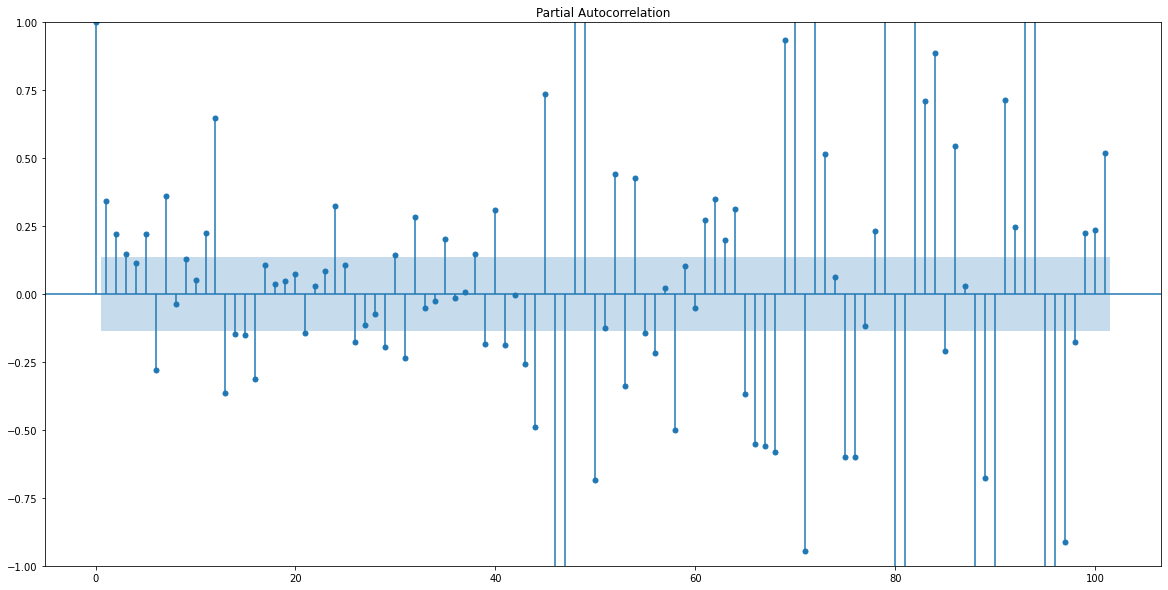

In [21]:
#Plot partial correlation to see how past data affects future data 
from statsmodels.graphics.tsaplots import plot_pacf
plt.rc("figure", figsize=(20, 10))
pacf = plot_pacf(to_use['AMOUNT'], lags=101)
plt.show()
#we will train the AR model of order 69. As the correlation is significant and has a fairly high r-score

In [22]:
train.reset_index(inplace=True)
test.reset_index(inplace = True)

In [23]:
#Train auto-reg model
from statsmodels.tsa.ar_model import AutoReg
autoreg_train = train['AMOUNT']
autoreg_test = test['AMOUNT']

ar_model = AutoReg(autoreg_train, lags=12).fit()
print(ar_model.summary())

                            AutoReg Model Results                             
Dep. Variable:                 AMOUNT   No. Observations:                  156
Model:                    AutoReg(12)   Log Likelihood               -3080.229
Method:               Conditional MLE   S.D. of innovations      471553858.070
Date:                Tue, 30 Aug 2022   AIC                           6188.459
Time:                        12:10:11   BIC                           6230.036
Sample:                            12   HQIC                          6205.354
                                  156                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       4.338e+08   1.54e+08      2.816      0.005    1.32e+08    7.36e+08
AMOUNT.L1      0.0189      0.048      0.395      0.693      -0.075       0.113
AMOUNT.L2     -0.0655      0.048     -1.377      0.1

([<matplotlib.axis.XTick at 0x15122a07040>,
 [Text(1, 0, '2019-01'),
  Text(2, 0, '2019-02'),
  Text(3, 0, '2019-03'),
  Text(4, 0, '2019-04'),
  Text(5, 0, '2019-05'),
  Text(6, 0, '2019-06'),
  Text(7, 0, '2019-07'),
  Text(8, 0, '2019-08'),
  Text(9, 0, '2019-09'),
  Text(10, 0, '2019-10'),
  Text(11, 0, '2019-11'),
  Text(12, 0, '2019-12'),
  Text(13, 0, '2020-01'),
  Text(14, 0, '2020-02'),
  Text(15, 0, '2020-03'),
  Text(16, 0, '2020-04'),
  Text(17, 0, '2020-05'),
  Text(18, 0, '2020-06'),
  Text(19, 0, '2020-07'),
  Text(20, 0, '2020-08'),
  Text(21, 0, '2020-09'),
  Text(22, 0, '2020-10'),
  Text(23, 0, '2020-11'),
  Text(24, 0, '2020-12'),
  Text(25, 0, '2021-01'),
  Text(26, 0, '2021-02'),
  Text(27, 0, '2021-03'),
  Text(28, 0, '2021-04'),
  Text(29, 0, '2021-05'),
  Text(30, 0, '2021-06'),
  Text(31, 0, '2021-07'),
  Text(32, 0, '2021-08'),
  Text(33, 0, '2021-09'),
  Text(34, 0, '2021-10'),
  Text(35, 0, '2021-11'),
  Text(36, 0, '2021-12'),
  Text(37, 0, '2022-01'),
  T

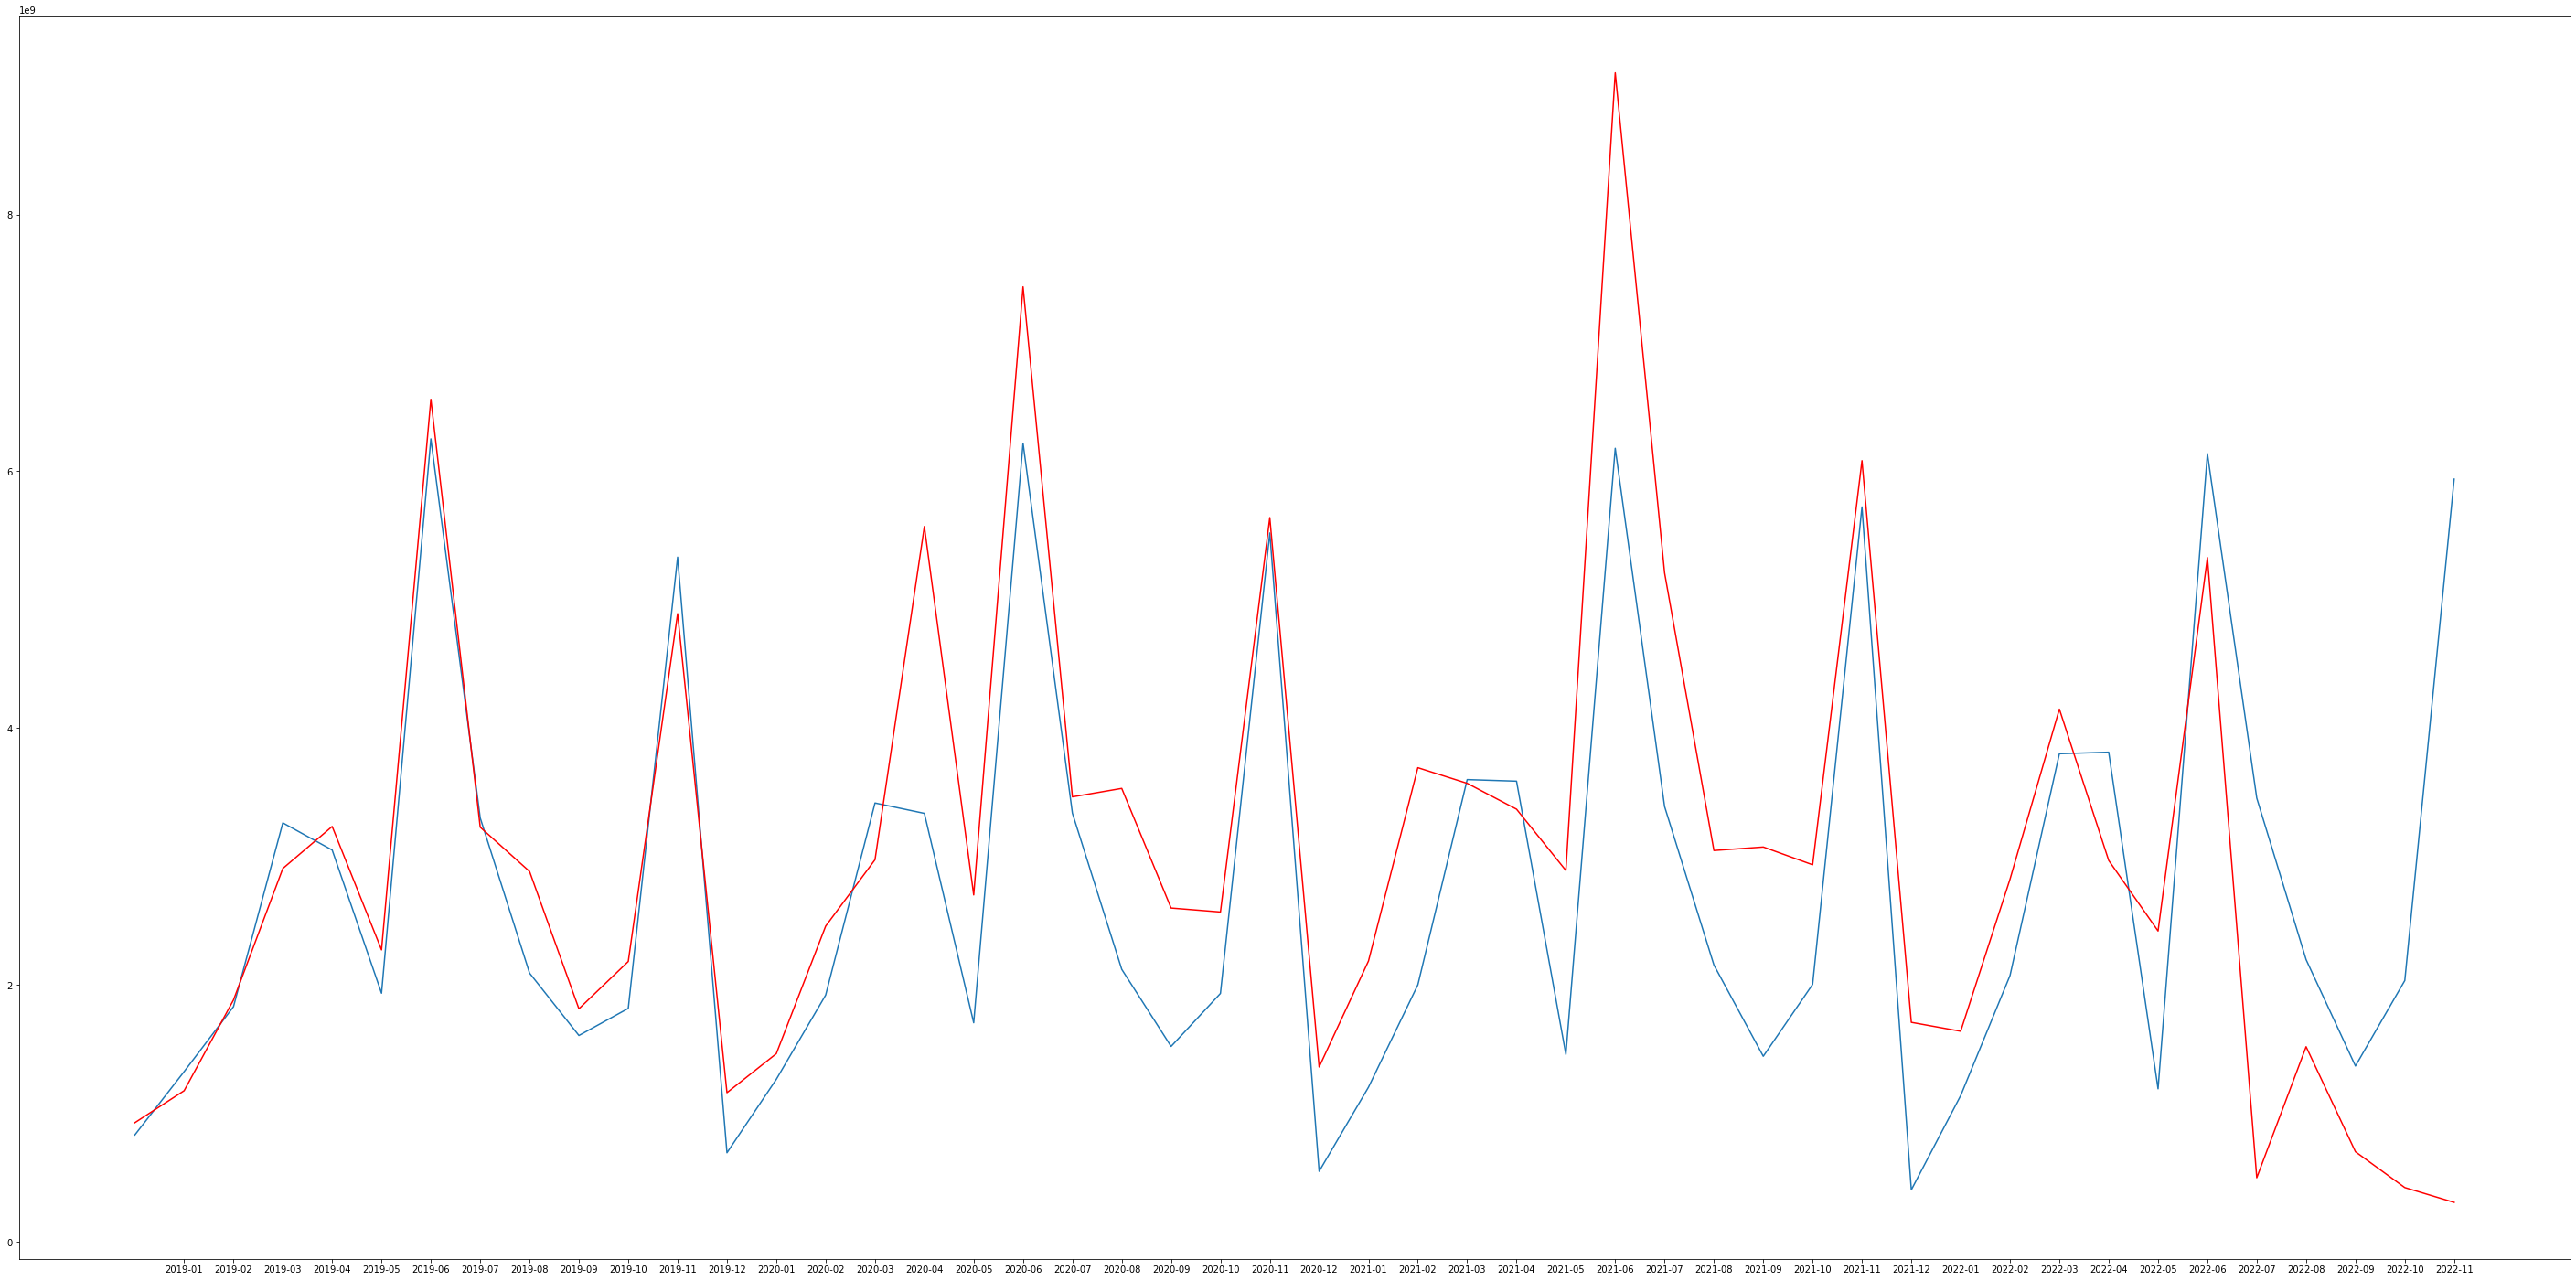

In [24]:
# Make the predictions
plt.figure(figsize=(50,25))
pred = ar_model.predict(start=len(autoreg_train), end=(len(to_use)-1), dynamic=False)
#
# Plot the prediction vs test data
#
from matplotlib import pyplot
pyplot.plot(pred.to_numpy())
pyplot.plot(autoreg_test.to_numpy(), color='red')

x_labels = test['Date/Month'][:-1]
x_ticks = range(1, len(test['Date/Month']))
plt.xticks(ticks=x_ticks, labels=x_labels)

In [25]:
list1 = ['']*156
list2 = pred.to_list()
to_add = list1+list2

In [26]:
to_use['Predictions'] = to_add

In [27]:
to_use[-48:]

,Unnamed: 0,index,FIN_CODE,AMOUNT,SEBRA_PAY_CODE,Year,Month,Day,Predictions
Date/Month,,,,,,,,,
2019-01,28387036944,28387036944,12703900069293,9.282765e+08,414578,22584534,11186,253102,8.32873e+08
2019-02,42670905857,42670905857,28081815927693,1.177595e+09,887682,33535590,33220,355048,1.32645e+09
2019-03,45968067236,45968067236,18229507627702,1.883885e+09,925526,35879649,53313,376140,1.83147e+09
2019-04,83082296638,83082296638,35614619194437,2.907730e+09,1909432,64349568,127488,625419,3.263e+09
2019-05,59499829272,59499829272,22764031606859,3.234856e+09,1078431,45740445,113275,383475,3.05153e+09
2019-06,46726216790,46726216790,18647974701372,2.273980e+09,779228,35673711,106014,301825,1.93655e+09
2019-07,43386023043,43386023043,20020638723383,6.560934e+09,669104,33204474,115122,280109,6.25309e+09
2019-08,43134129807,43134129807,15613940807186,3.229290e+09,664468,32897586,130352,270154,3.30141e+09
2019-09,46660057700,46660057700,18933404081012,2.884538e+09,886298,34958985,155835,292556,2.09311e+09


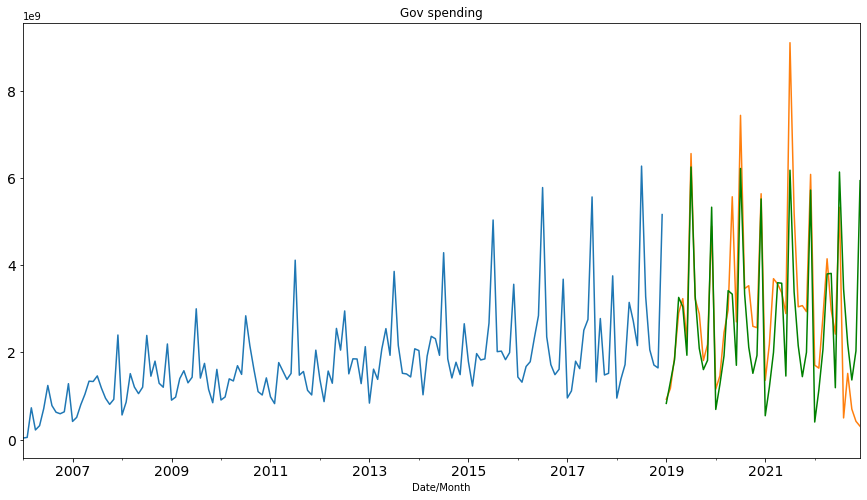

In [28]:
#Plot our regression result
train.set_index('Date/Month', inplace = True)
test.set_index('Date/Month', inplace = True)
train.AMOUNT.plot(figsize=(15,8), title= 'Gov spending', fontsize=14, label='train') 
test.AMOUNT.plot(figsize=(15,8), title= 'Gov spending', fontsize=14, label='test')
plt.plot(to_use['Predictions'][-48:], label='AutoReg', color = 'green') 
#plt.legend(loc='best') 
plt.show()

In [29]:
#Compute metrics
mae = mean_absolute_error(to_use['AMOUNT'][-48:], to_use['Predictions'][-48:])
mse = mean_squared_error(to_use['AMOUNT'][-48:], to_use['Predictions'][-48:])
rms = m.sqrt(mean_squared_error(to_use['AMOUNT'][-48:], to_use['Predictions'][-48:])) 
print('Mean absolute error: ', mae)
print('Mean_squared_error', mse)
print('Root mean squared error: ',rms)

Mean absolute error:  913886193.6128527
Mean_squared_error 1.7820651570808497e+18
Root mean squared error:  1334940132.395775


In [30]:
#Now let's predict the data for next year
df[df['Year']>2019]['AMOUNT'].sum()

112605940495.23001

In [31]:
def nse(predictions, targets):
    return 1-(np.sum((predictions-targets)**2)/np.sum((targets-np.mean(targets))**2))

print(nse(to_use['Predictions'][-48:], to_use['AMOUNT'][-48:]))

0.4722922720863628


In [32]:
ar_model

In [33]:
#adding Date/Month
new_dates = []
for i in range(1, 13):
    if i > 9:
        s = '2023-'+str(i)+'-01'
        new_dates.append(datetime.datetime.strptime(s, '%Y-%m-%d')) 
    else:
        s = '2023-0'+str(i)+'-01'
        new_dates.append(datetime.datetime.strptime(s, '%Y-%m-%d'))

In [34]:
#-len(new_dates)
emp = len(to_use)*['']
new_dates = emp+new_dates

In [35]:
to_use.reset_index(inplace = True)

In [36]:
new_dates=np.array(new_dates)

In [37]:
to_use.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 204 entries, 0 to 203
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype    
---  ------          --------------  -----    
 0   Date/Month      204 non-null    period[M]
 1   Unnamed: 0      204 non-null    int64    
 2   index           204 non-null    int64    
 3   FIN_CODE        204 non-null    int64    
 4   AMOUNT          204 non-null    float64  
 5   SEBRA_PAY_CODE  204 non-null    int64    
 6   Year            204 non-null    int64    
 7   Month           204 non-null    int64    
 8   Day             204 non-null    int64    
 9   Predictions     204 non-null    object   
dtypes: float64(1), int64(7), object(1), period[M](1)
memory usage: 16.1+ KB


In [38]:
to_use = pd.concat([to_use, pd.Series(new_dates)], axis = 1)

In [39]:
to_use[-48:]

,Date/Month,Unnamed: 0,index,FIN_CODE,AMOUNT,SEBRA_PAY_CODE,Year,Month,Day,Predictions,0
168,2020-01,3.615396e+10,3.615396e+10,2.090164e+13,1.162266e+09,492651.0,25864080.0,12804.0,267344.0,6.94515e+08,
169,2020-02,5.170809e+10,5.170809e+10,1.779373e+13,1.466020e+09,802112.0,36644820.0,36282.0,331377.0,1.26635e+09,
170,2020-03,6.759541e+10,6.759541e+10,2.736932e+13,2.458814e+09,1150925.0,47439700.0,70455.0,369126.0,1.92198e+09,
171,2020-04,8.733922e+10,8.733922e+10,3.911105e+13,2.975975e+09,1775810.0,61072680.0,120936.0,457571.0,3.41771e+09,
172,2020-05,6.491165e+10,6.491165e+10,3.391765e+13,5.570672e+09,999318.0,45241940.0,111985.0,292818.0,3.337e+09,
173,2020-06,5.217818e+10,5.217818e+10,2.826180e+13,2.701734e+09,718714.0,36329700.0,107910.0,289330.0,1.70638e+09,
174,2020-07,6.324955e+10,6.324955e+10,5.144452e+13,7.436970e+09,846249.0,43627960.0,151186.0,393276.0,6.21935e+09,
175,2020-08,5.773566e+10,5.773566e+10,5.284210e+13,3.465412e+09,754193.0,39527360.0,156544.0,357570.0,3.33863e+09,
176,2020-09,7.052975e+10,7.052975e+10,6.762319e+13,3.531252e+09,905666.0,47995200.0,213840.0,407714.0,2.12256e+09,
177,2020-10,7.773844e+10,7.773844e+10,3.925258e+13,2.599945e+09,1182407.0,52566460.0,260230.0,473357.0,1.52232e+09,


In [40]:
to_use.rename({0: 'New_Dates'}, inplace=True, axis = 1)

In [41]:
to_use[-48:]

,Date/Month,Unnamed: 0,index,FIN_CODE,AMOUNT,SEBRA_PAY_CODE,Year,Month,Day,Predictions,New_Dates
168,2020-01,3.615396e+10,3.615396e+10,2.090164e+13,1.162266e+09,492651.0,25864080.0,12804.0,267344.0,6.94515e+08,
169,2020-02,5.170809e+10,5.170809e+10,1.779373e+13,1.466020e+09,802112.0,36644820.0,36282.0,331377.0,1.26635e+09,
170,2020-03,6.759541e+10,6.759541e+10,2.736932e+13,2.458814e+09,1150925.0,47439700.0,70455.0,369126.0,1.92198e+09,
171,2020-04,8.733922e+10,8.733922e+10,3.911105e+13,2.975975e+09,1775810.0,61072680.0,120936.0,457571.0,3.41771e+09,
172,2020-05,6.491165e+10,6.491165e+10,3.391765e+13,5.570672e+09,999318.0,45241940.0,111985.0,292818.0,3.337e+09,
173,2020-06,5.217818e+10,5.217818e+10,2.826180e+13,2.701734e+09,718714.0,36329700.0,107910.0,289330.0,1.70638e+09,
174,2020-07,6.324955e+10,6.324955e+10,5.144452e+13,7.436970e+09,846249.0,43627960.0,151186.0,393276.0,6.21935e+09,
175,2020-08,5.773566e+10,5.773566e+10,5.284210e+13,3.465412e+09,754193.0,39527360.0,156544.0,357570.0,3.33863e+09,
176,2020-09,7.052975e+10,7.052975e+10,6.762319e+13,3.531252e+09,905666.0,47995200.0,213840.0,407714.0,2.12256e+09,
177,2020-10,7.773844e+10,7.773844e+10,3.925258e+13,2.599945e+09,1182407.0,52566460.0,260230.0,473357.0,1.52232e+09,


In [42]:
to_use['Date'] = to_use['Date/Month'][:12].append(to_use['New_Dates'][-12:])

In [43]:
to_use['Date'] = pd.to_datetime(to_use['Date'], errors='coerce')

In [44]:
to_use['Date'] = to_use['Date'].dt.to_period('M')

In [45]:
to_use['Date/Month'] = to_use['Date/Month'][:-12].append(to_use['Date'][-12:])

In [46]:
#pd.set_option('display.max_rows', None)

In [47]:
pred = ar_model.predict(start=len(to_use)-12, end=len(to_use), dynamic=False)

In [48]:
pred

204    2.664441e+08
205    1.067969e+09
206    2.140836e+09
207    4.016597e+09
208    4.021236e+09
209    9.016562e+08
210    6.095953e+09
211    3.534948e+09
212    2.250145e+09
213    1.289848e+09
214    2.029116e+09
215    6.169206e+09
216    1.348341e+08
dtype: float64

In [49]:
to_use['Predictions'] = to_use['Predictions'][:-12].append(pred)

In [50]:
to_use.set_index('Date/Month',inplace = True)

In [55]:
to_use.reset_index('Date/Month', inplace = True)

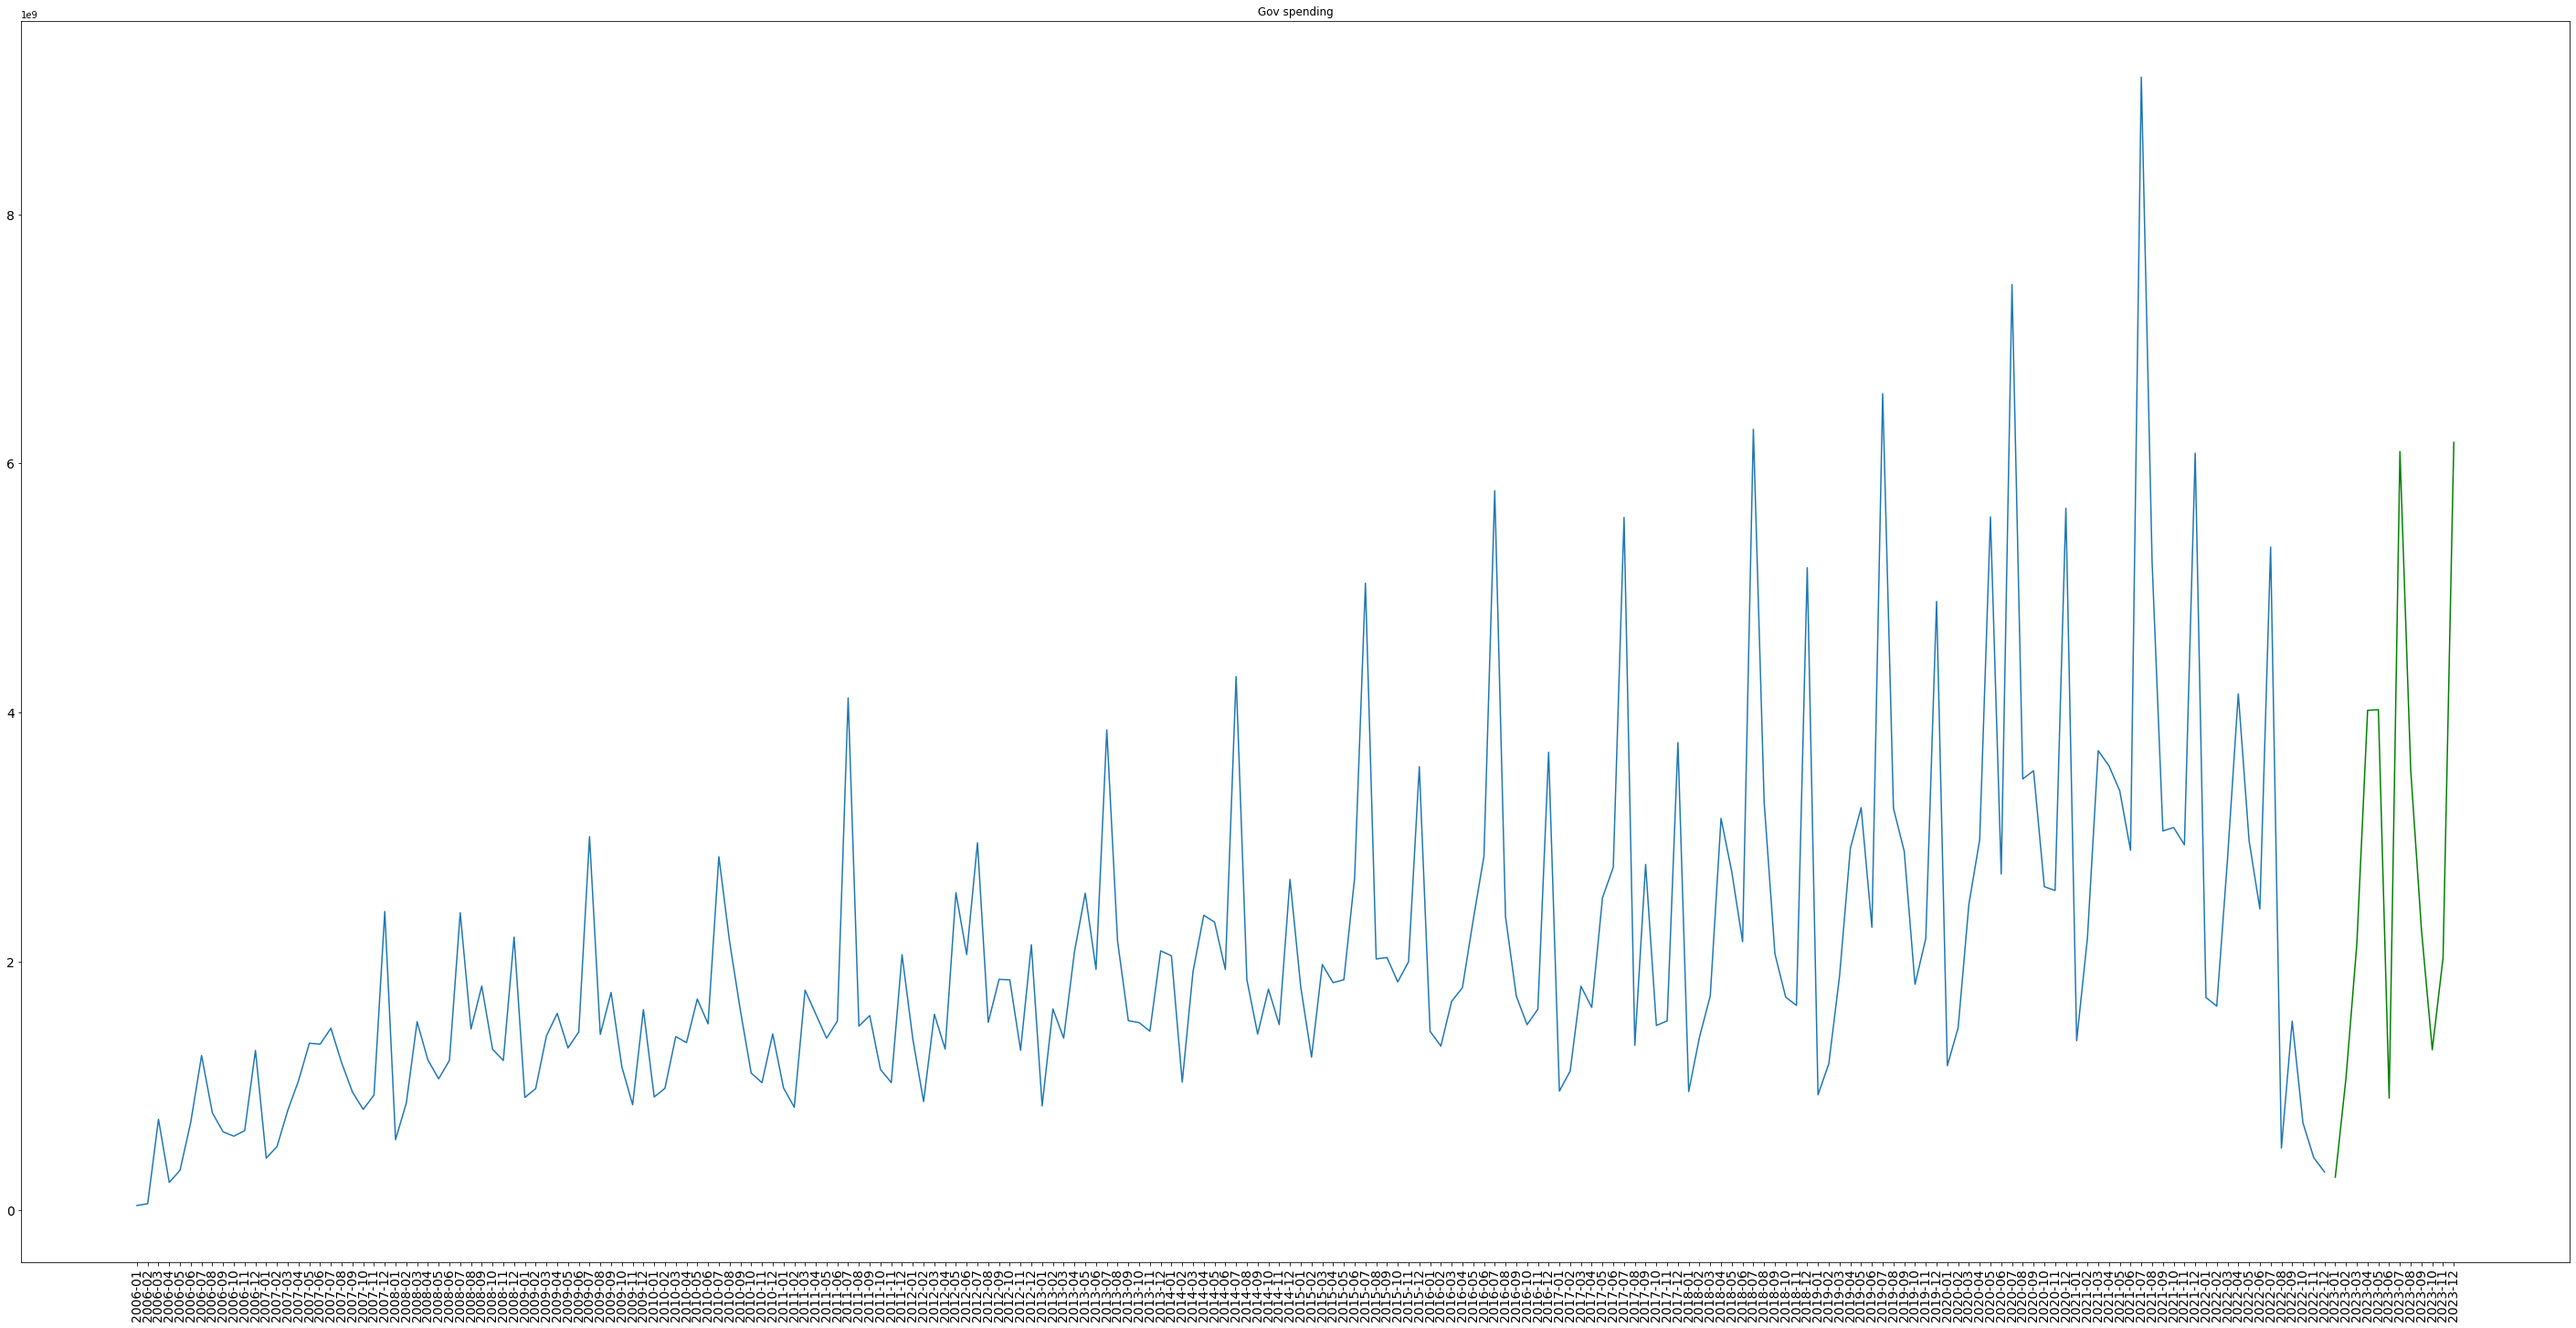

In [61]:
to_use.AMOUNT.plot(figsize=(50,25), title= 'Gov spending', fontsize=14, label='test')
plt.plot(to_use['Predictions'][-12:], label='AutoReg', color = 'green') 
x_labels = to_use['Date/Month']
x_ticks = range(len(to_use['Date/Month']))
plt.xticks(ticks=x_ticks, labels=x_labels, rotation = 90)
plt.show()

In [62]:
df.head()

,Unnamed: 0,index,SETTLEMENT_DATE,CLIENT_RECEIVER_NAME,CLIENT_RECEIVER_ACC,CLIENT_RECEIVER_BIC,FIN_CODE,AMOUNT,CURRENCY,REASON1,...,PRIMARY_ORGANIZATION,DATE,Year,Month,Day,IsBank,IsMunicipality,IsType,Prime Ministers,Date/Month
0,0,0,2006-06-06,българска народна банка,BG40BNBG96611000066123,BNBGBGSD,100000004,10000.00,BGN,NaN,...,министерство на финансите,06-2006,2006,6,6,Yes,No,Bank,Sergey Stanishev,2006-06
1,1,1,2006-06-06,мобилтел еад,BG40CITI92501010005505,CITIBGSF,100000004,20710.63,BGN,Ф РА,...,министерство на финансите,06-2006,2006,6,6,No,No,Else,Sergey Stanishev,2006-06
2,2,2,2006-06-06,тд на нап бургас,BG24BUIB78993100650000,BUIBBGSF,100110022,5000.00,BGN,ИЗДРЪЖКА М.06/2006,...,министерство на финансите,06-2006,2006,6,6,No,No,Else,Sergey Stanishev,2006-06
3,3,3,2006-06-06,агенция дага с оод,BG91BFTB76301051091913,BFTBBGSF,228000009,7280.00,BGN,ОХРАНА ДОГ.,...,министерство на земеделието и горите,06-2006,2006,6,6,No,No,Else,Sergey Stanishev,2006-06
4,4,4,2006-06-06,иа бг,BG95BACX96603110007824,BACXBGSF,228000009,5000.00,BGN,ИЗДРЪЖКА,...,министерство на земеделието и горите,06-2006,2006,6,6,No,No,Else,Sergey Stanishev,2006-06
